In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch as torch 
import torch.nn as nn
import torch.optim as optim
import dataset_utils
import torch.nn.functional as F
import torchvision.models as models
from pytorch_metric_learning import distances, losses, miners, reducers

In [3]:

def binarize_hard(x):
    return torch.where(x > 0, 1.0, -1.0)

In [4]:
def activation_binarize(a):
    a = torch.where(a<-1,-1,a)
    a = torch.where(a>1,1,a)
    mask1 = (a >= -1) & (a < 0)
    a[mask1] = 2 * a[mask1] + a[mask1]*a[mask1]
    #a[mask1] = 0
    mask2 = (a >= 0) & (a < 1)
    a[mask2] = 2 * a[mask2] - a[mask2]*a[mask2]
    #a = torch.where((a >= -1) & (a < 0),2*a + torch.pow(a,2) )
    #a = torch.where((a >= 0) & (a < 1), 2*a- torch.pow(a,2))
    #    a [a < -1] = -1
    #    a [a > 1]   =  1
    #    a [(a >= -1) & (a < 0)] = 2*a[(a >= -1) & (a < 0)] + torch.pow(a [(a >= -1) & (a < 0)],2)
    #    a [(a >= 0) & (a < 1)] = 2*a[(a >= 0) & (a < 1)] - torch.pow(a [(a >= 0) & (a < 1)],2)
    return a


In [5]:
def binary_sparse_encode(w, sparsity):
    # Flatten the weight tensor
    #w_flat = w.reshape(-1)
    #print(w.size())

    # Calculate the threshold value for sparsity
    threshold = torch.kthvalue(torch.abs(w), int(sparsity * w.numel())).values

    # Apply binary sparse encoding
    w_sparse = torch.where(torch.abs(w) < threshold, torch.tensor(0.), activation_binarize(w))

    return w_sparse

In [6]:
import torch

# Set the tensor size and block size
def obtain_sparsity(w,block_size,sparsity):
    tensor_size = w.shape[1]
    #print(tensor_size)
    num_rows = w.shape[0]
    block_size = block_size

    # Compute the number of blocks
    num_blocks = tensor_size // block_size
    #print(num_blocks)
    # Create a sparse binary code for each block
    blocks = []
    for j in range(num_rows):
        for i in range(num_blocks):
            # Create a block of zeros
            #print("i",i)
            #print("j",j)
            block = w[j,i*block_size:(i+1)*block_size].data.clone()
            #print(block)
            block = binary_sparse_encode(block, sparsity) 
            # Add the block to the list of blocks
            w[j,i*block_size:(i+1)*block_size] = block.clone()
            #blocks.append(block)
            #print(block)
    # Concatenate the blocks to form the sparse binary tensor
    sparse_binary_tensor = w.data.clone()
    # Print the resulting tensor
    return sparse_binary_tensor

In [7]:
import torch

a = torch.randn(5,10)
print(a)
sparse_a = obtain_sparsity(a,5,0.8)
print(f"shape of sparse_a",sparse_a.shape)
print(sparse_a)

tensor([[-0.3587, -1.2301,  1.4772,  1.5873, -0.4807,  1.7282, -0.7645, -1.5076,
          0.4562,  0.0380],
        [ 0.8640,  1.1911, -0.7465,  0.3423,  0.6491, -1.5532,  0.5984,  1.4406,
          1.6068,  0.3420],
        [-0.3904,  0.8215,  1.3790, -1.2059, -1.6270, -0.2218, -2.0822, -1.4266,
         -0.3863, -0.5727],
        [ 0.5741, -1.8381,  0.4561,  0.6806,  1.0074, -0.1781,  0.0094, -1.0920,
         -0.8579,  0.5511],
        [ 2.0721, -1.4283,  1.1602,  0.1058,  2.3922, -0.7764, -1.7538, -0.6910,
          0.2333,  0.6688]])
shape of sparse_a torch.Size([5, 10])
tensor([[ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000, -1.0000,
          0.0000,  0.0000],
        [ 0.9815,  1.0000,  0.0000,  0.0000,  0.0000, -1.0000,  0.0000,  0.0000,
          1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000, -1.0000,  0.0000, -1.0000, -1.0000,
          0.0000,  0.0000],
        [ 0.0000, -1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000, -1.0000,
        

In [8]:
# Reference code
class BinaryModel(nn.Module):
    def __init__(self, dim, D, num_classes, enc_type='RP', binary=True, device='cpu', sparsity = 0.6, block_size =10, kargs=None):
        super(BinaryModel, self).__init__()
        self.enc_type, self.binary = enc_type, binary	
        self.device = device
        self.sparsity = sparsity
        self.block_size = block_size
        if enc_type in ['RP', 'RP-COS']:
            self.rp_layer = nn.Linear(dim, D).to(device)
            self.class_hvs = torch.zeros(num_classes, D).float().to(device)
            self.class_hvs_nb = torch.zeros(num_classes, D).float().to(device)
        else:
            pass
    #hard sigmoid    
    def weight_binarize(self, W):
       W = torch.where(W<-1,-1,W)
       W = torch.where(W>1,1,W)
       mask1 = (W >= -1) & (W < 0)
       W[mask1] = 2 * W[mask1] + W[mask1]*W[mask1]
       mask2 = (W >= 0) & (W < 1)
       W[mask2] = 2 * W[mask2] - W[mask2]*W[mask2]
       # W[W > 1] = 1
       return W
    #using Bi-Real Approximation     
    def activation_binarize(self,a):
       a = torch.where(a<-1,-1,a)
       a = torch.where(a>1,1,a)
       mask1 = (a >= -1) & (a < 0)
       a[mask1] = 2 * a[mask1] + a[mask1]*a[mask1]
       #a[mask1] = 0
       mask2 = (a >= 0) & (a < 1)
       a[mask2] = 2 * a[mask2] - a[mask2]*a[mask2]
       #a = torch.where((a >= -1) & (a < 0),2*a + torch.pow(a,2) )
       #a = torch.where((a >= 0) & (a < 1), 2*a- torch.pow(a,2))
    #    a [a < -1] = -1
    #    a [a > 1]   =  1
    #    a [(a >= -1) & (a < 0)] = 2*a[(a >= -1) & (a < 0)] + torch.pow(a [(a >= -1) & (a < 0)],2)
    #    a [(a >= 0) & (a < 1)] = 2*a[(a >= 0) & (a < 1)] - torch.pow(a [(a >= 0) & (a < 1)],2)
       return a

    def encoding(self, x):
        if self.enc_type == 'RP':
            #x = self.activation_binarize(x) 
            #need not binarize the inputs 
            #progressively binarize the inputs, after training the weights
            #add some print statements and check 
            #print("The value of weights, before binarization")
            #print(self.rp_layer.weight.data)
            #comment
            #do it with masking
            weights = self.rp_layer.weight.data.clone()
            weights_bin = self.weight_binarize(weights)
            #self.rp_layer.weight.data = weights_bin.clone() 
            weight_sparse = obtain_sparsity(weights_bin, self.block_size,self.sparsity)
            self.rp_layer.weight.data = weight_sparse.clone()
            out = self.rp_layer(x)
            #print("The value of weights, after binarization")
            #print(self.rp_layer.weight.data)
        else:
                pass
        
        return self.activation_binarize(out) if self.binary else out
    
    #Forward Function
    def forward(self, x, embedding=False):
        out = self.encoding(x)
        #print("shape of weight",self.model.rp_layer.weight.shape)
        if embedding:
            out = out
        else:
            out = self.similarity(class_hvs=binarize_hard(self.class_hvs), enc_hv=out)   
        return out
    
    def init_class(self, x_train, labels_train):
        out = self.encoding(x_train)
        for i in range(x_train.size()[0]):
            self.class_hvs[labels_train[i]] += out[i]

        self.class_hvs = binarize_hard(self.class_hvs)
        
    def HD_train_step(self, x_train, y_train, lr=1.0):
        shuffle_idx = torch.randperm(x_train.size()[0])
        x_train = x_train[shuffle_idx]
        train_labels = y_train[shuffle_idx]
        l= list(self.rp_layer.parameters())
        enc_hvs = binarize_hard(self.encoding(x_train))
        for i in range(enc_hvs.size()[0]):
            sims = self.similarity(self.class_hvs, enc_hvs[i].unsqueeze(dim=0))
            predict = torch.argmax(sims, dim=1)
            
            if predict != train_labels[i]:
                self.class_hvs_nb[predict] -= lr * enc_hvs[i]
                self.class_hvs_nb[train_labels[i]] += lr * enc_hvs[i]
            
            self.class_hvs.data = binarize_hard(self.class_hvs_nb)
    
    def similarity(self, class_hvs, enc_hv):
	    return torch.matmul(enc_hv, class_hvs.t())/class_hvs.size()[1]
    
    

In [9]:
nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset('mnist', 256, "cpu")


In [10]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
num_samples = 1000
train_loader_truncated = Subset(train_loader.dataset, range(num_samples))
train_loader_truncated = DataLoader(train_loader_truncated, batch_size=256, shuffle=True)

In [27]:
import torch.nn.utils.prune as prune
model = BinaryModel(dim = nFeatures, D=4000, num_classes=nClasses, enc_type='RP', device="cpu", sparsity = 0.8, block_size=50)
#prune.ln_structured(model.rp_layer, name='weight', amount=0.8, dim=0, n=1)

In [28]:
lr = 0.01
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0.0)


In [29]:

def HD_test(model, x_test, y_test):
	out = model(x_test, embedding=False)
	preds = torch.argmax(out, dim=-1)
	acc = torch.mean((preds==y_test).float())	
	return acc

def get_Hamming_margin(model, x_test, y_test=None):
	def Hamming_distance(a, b):
		D = a.size()[1]
		return (D - a @ b.T)/2

	# Compute mean Hamming distance between class HVS
	class_hvs = binarize_hard(model.class_hvs.data)
	class_Hamming_distance = Hamming_distance(class_hvs, class_hvs)
	mean_class_Hamming_distance = torch.mean(class_Hamming_distance).item()
	

	# Compute test samples' Hamming distance
	test_enc_hvs = binarize_hard(model(x_test, True)) 
	test_Hamming_dist = Hamming_distance(test_enc_hvs, class_hvs)

	sorted_test_Hamming_distance, _ = torch.sort(test_Hamming_dist, dim=-1, descending=False)
	test_enc_hvs_Hamming_margin = (sorted_test_Hamming_distance[:,1:]-sorted_test_Hamming_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cpu()
	mean_test_Hamming_margin = torch.mean(test_enc_hvs_Hamming_margin).item()

	res_dict = {
		"avg_class_Hamming_dist": mean_class_Hamming_distance,
		"avg_test_Hamming_margin": mean_test_Hamming_margin
	}
	return mean_test_Hamming_margin

In [30]:

num_metric_epochs = 2
device = "cpu"
accuracies = []


In [31]:

accuracies.append(HD_test(model, x_test, y_test).item())
margins = []
margins.append(get_Hamming_margin(model, x_test, y_test))

In [32]:

#loss_class = CustomLoss(model, distance = distance,reducer = reducer,dimension = 1000, segment_size = 100, sparsity_factor= 80, penalty_factor = 0.5)
#loss_func = loss_class.loss_calc()
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0) 


In [33]:

model.class_hvs = nn.parameter.Parameter(data=model.class_hvs)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard", )

In [34]:
def metric_train(model, mining_func, device, train_loader, optimizer, epoch,segment_length, zeroes):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data.reshape(data.size()[0],-1))
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings,labels,indices_tuple)
        loss.backward()
        optimizer.step()
    

In [35]:
### pytorch-metric-learning using Triplet margin loss ###
print("Triplet Loss")
for epoch_i in range(1, num_metric_epochs + 1):
    metric_train(model, mining_func, device, train_loader_truncated, optimizer, epoch_i,segment_length=50, zeroes=25)
    #print("finished metric train")
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins.append(get_Hamming_margin(model, x_test, y_test))
    print("Epoch",epoch_i)
    #print("Accuracy",HD_test(model, x_test, y_test).item())


Triplet Loss
Epoch 1
Epoch 2


In [36]:
#weights_updated = torch.zeros(model.rp_layer.weight.size())
#weights_updated = model.rp_layer.weight.data.clone()    
#weights_updated = binarize_hard(weights_updated)
#weights_updated = binary_sparse_encode(weights_updated, 0.8)
#make the binarize function bipolar
#model.rp_layer.weight.data  = weights_updated.clone()
print("Trained Weights")
print(model.rp_layer.weight.data)

Trained Weights
tensor([[ 1.,  0.,  0.,  ...,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  ..., -1.,  1.,  1.],
        [ 0.,  1., -1.,  ...,  1., -1., -1.],
        ...,
        [ 0.,  0.,  0.,  ...,  1., -1., -1.],
        [-1., -1.,  0.,  ...,  1., -1.,  1.],
        [ 0.,  0.,  0.,  ...,  1., -1.,  1.]])


In [37]:
print(model.rp_layer.weight)

Parameter containing:
tensor([[ 1.,  0.,  0.,  ...,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  ..., -1.,  1.,  1.],
        [ 0.,  1., -1.,  ...,  1., -1., -1.],
        ...,
        [ 0.,  0.,  0.,  ...,  1., -1., -1.],
        [-1., -1.,  0.,  ...,  1., -1.,  1.],
        [ 0.,  0.,  0.,  ...,  1., -1.,  1.]], requires_grad=True)


In [38]:
num_HD_epoch = 20
HD_lr = 0.1
print(model.rp_layer.weight)
for epoch_i in range(1, num_HD_epoch+1):
    model.HD_train_step(x_train, y_train, lr=HD_lr)
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins.append(get_Hamming_margin(model, x_test, y_test))
    print("Epoch",epoch_i)


Parameter containing:
tensor([[ 1.,  0.,  0.,  ...,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  ..., -1.,  1.,  1.],
        [ 0.,  1., -1.,  ...,  1., -1., -1.],
        ...,
        [ 0.,  0.,  0.,  ...,  1., -1., -1.],
        [-1., -1.,  0.,  ...,  1., -1.,  1.],
        [ 0.,  0.,  0.,  ...,  1., -1.,  1.]], requires_grad=True)
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


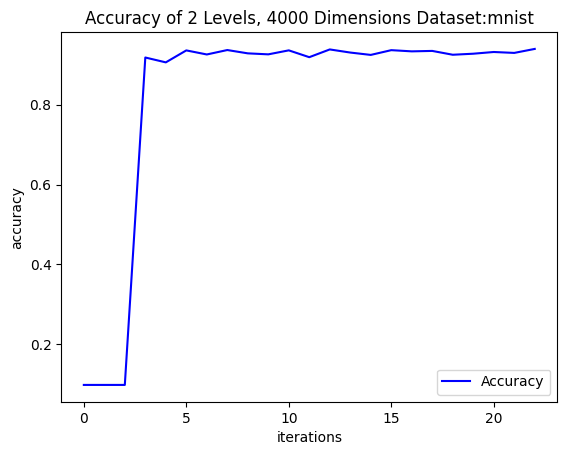

Maximum Accuracy:0.9398000240325928
Parameter containing:
tensor([[ 1.,  0.,  0.,  ...,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  ..., -1.,  1.,  1.],
        [ 0.,  1., -1.,  ...,  1., -1., -1.],
        ...,
        [ 0.,  0.,  0.,  ...,  1., -1., -1.],
        [-1., -1.,  0.,  ...,  1., -1.,  1.],
        [ 0.,  0.,  0.,  ...,  1., -1.,  1.]], requires_grad=True)


In [39]:
plt.plot(accuracies, label="Accuracy", c = "blue")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.title("Accuracy of 2 Levels, 4000 Dimensions Dataset:mnist")
plt.legend()
plt.show()
print("Maximum Accuracy:{}".format(max(accuracies)))
torch.save(model, './model/model.pth')
print(model.rp_layer.weight)

In [144]:
print(model.rp_layer.weight)
weight_array = model.rp_layer.weight.detach().numpy()
#print(torch.tensor(weight_array, requires_grad=True))
#print(weight_array == model.rp_layer.weight)

Parameter containing:
tensor([[ 0.,  0., -1.,  ..., -1.,  1.,  1.],
        [ 0.,  0.,  0.,  ..., -1., -1.,  1.],
        [-1.,  0.,  0.,  ..., -1.,  1.,  1.],
        ...,
        [ 0.,  0.,  0.,  ...,  1., -1.,  1.],
        [ 0.,  0.,  0.,  ...,  1.,  1., -1.],
        [ 0.,  0.,  0.,  ...,  1.,  1., -1.]], requires_grad=True)


In [157]:
from gkpd import gkpd
from gkpd.tensorops import kron
class KroneckerDecomposition_new(nn.Module):
        # def __init__(self, dim, D, num_classes, enc_type='RP', binary=True, device='cpu', kargs=None):
        # super(BinaryModel, self).__init__()
    def __init__(self,A,B, dim, D, num_classes,block_size,sparsity ):
        super(KroneckerDecomposition_new, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor(A))
        self.B = torch.nn.Parameter(torch.tensor(B))
        #self.weight_kron = torch.nn.Parameter(self.weight_kron)
        self.class_hvs = torch.zeros(num_classes, D).float().to(device)
        self.class_hvs_nb = torch.zeros(num_classes, D).float().to(device)
        self.sparsity = sparsity
        self.block_size = block_size

    def weight_binarize(self, W):
       W = torch.where(W<-1,-1,W)
       W = torch.where(W>1,1,W)
       mask1 = (W >= -1) & (W < 0)
       W[mask1] = 2 * W[mask1] + W[mask1]*W[mask1]
       mask2 = (W >= 0) & (W < 1)
       W[mask2] = 2 * W[mask2] - W[mask2]*W[mask2]
       W = W.float()
       return W
        
    def forward(self,x, embedding=False):
        out = self.encoding(x)
        if embedding:
            out = out
        else:
            out = self.similarity(class_hvs=binarize_hard(self.class_hvs), enc_hv=out)   
        return out
    
    def encoding(self,x):
        #print("Entering Encoding")
        bin_A = self.weight_binarize(self.A)
        bin_B = self.weight_binarize(self.B)
        #below two lines for reference
        #weight_sparse = obtain_sparsity(weights_bin, self.block_size,self.sparsity)
        #self.rp_layer.weight.data = weight_sparse.clone()
        #cyclic rotation to generate mask 
        #or some other predictable way to achieve 
        bin_A_sparse = obtain_sparsity(bin_A,self.block_size, self.sparsity)
        bin_B_sparse = obtain_sparsity(bin_B,self.block_size, self.sparsity)
        weight_kron = kron(bin_A_sparse, bin_B_sparse).clone()
        weight_kron_size = list(weight_kron.size())
        weight_kron = weight_kron.view(weight_kron_size[0],weight_kron_size[1]).clone()
        #print("Finished reshape")
        out = torch.matmul(x,weight_kron.t())
        #print("Encoding Done")
        return self.weight_binarize(out)
    
    def init_class(self, x_train, labels_train):
        out = self.encoding(x_train)
        for i in range(x_train.size()[0]):
            self.class_hvs[labels_train[i]] += out[i]

        self.class_hvs = binarize_hard(self.class_hvs)
    
    def HD_train_step(self, x_train, y_train, lr=1.0):
        shuffle_idx = torch.randperm(x_train.size()[0])
        x_train = x_train[shuffle_idx]
        train_labels = y_train[shuffle_idx]
        #l= list(self.rp_layer.parameters())
        enc_hvs = binarize_hard(self.encoding(x_train))
        for i in range(enc_hvs.size()[0]):
            sims = self.similarity(self.class_hvs, enc_hvs[i].unsqueeze(dim=0))
            predict = torch.argmax(sims, dim=1)
            
            if predict != train_labels[i]:
                self.class_hvs_nb[predict] -= lr * enc_hvs[i]
                self.class_hvs_nb[train_labels[i]] += lr * enc_hvs[i]
            
            self.class_hvs.data = binarize_hard(self.class_hvs_nb)
    
    def similarity(self, class_hvs, enc_hv):
	    return torch.matmul(enc_hv, class_hvs.t())/class_hvs.size()[1]
    
    


In [151]:
def  metric_train_svd (model, loss_func, mining_func, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data.reshape(data.size()[0],-1))
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings,labels,indices_tuple)
        loss.backward()
        optimizer.step()


In [175]:

from gkpd import gkpd
from gkpd.tensorops import kron
from gkpd.tensorops import multidimensional_unfold

w = model.rp_layer.weight
w = w.view(1000,784,1,1)
#print(w.shape)
rank = 8
a_shape, b_shape = (rank, 2, 392, 1, 1), (rank, 500, 2, 1, 1)
#a, b = torch.randn(*a_shape), torch.randn(*b_shape)
#w = kron(a, b)
#print(w.shape)
#print(a.shape)
a_hat, b_hat = gkpd(w, a_shape[1:], b_shape[1:])
w_hat = kron(a_hat, b_hat)

    # Reconstruction error
print("Reconstruction error: {}".format(
round((torch.linalg.norm((w.reshape(-1) - w_hat.reshape(-1))).detach().numpy()).item(), 4)
))
print(a_hat)


Reconstruction error: 0.0008
tensor([[[[[ 5.3032e-01]],

          [[-6.1224e-01]],

          [[ 2.0136e-01]],

          ...,

          [[ 6.7715e+00]],

          [[-2.8483e+00]],

          [[ 1.1234e+01]]],


         [[[-3.7892e-01]],

          [[ 7.3485e-01]],

          [[-6.6858e-01]],

          ...,

          [[ 2.2590e+00]],

          [[ 7.4093e+00]],

          [[ 2.2665e+00]]]],



        [[[[-1.8133e-01]],

          [[-3.2817e-02]],

          [[ 6.3828e-01]],

          ...,

          [[-8.9608e+00]],

          [[ 5.3748e+00]],

          [[ 3.4480e+00]]],


         [[[ 1.1231e+00]],

          [[ 2.5481e-02]],

          [[ 9.5050e-01]],

          ...,

          [[ 2.0505e+00]],

          [[ 1.1202e+00]],

          [[ 8.3296e+00]]]],



        [[[[ 2.5427e-01]],

          [[-6.7767e-01]],

          [[ 1.9937e-01]],

          ...,

          [[-1.2730e+00]],

          [[ 2.2601e+00]],

          [[ 3.5722e+00]]],


         [[[ 2.1938e-01]],

         

In [174]:

a_hat_binarize = activation_binarize(a_hat)
print(a_hat_binarize.shape)
a_shape = a_hat_binarize.shape[1:3]
a_shape = tuple(a_shape)
print(a_shape)
# stride = 1
# stride = tuple(stride)
# print(stride)
#a_hat_sparse = obtain_sparsity(a_hat_binarize[1:],block_size=a_shape,)
a_hat_binarize_unfold = multidimensional_unfold(a_hat_binarize,a_shape,a_shape)
#print(a_hat_binarize_unfold.shape)


torch.Size([784, 2, 392, 1, 1])
(2, 392)


IndexError: tuple index out of range

In [67]:

print(*a_hat.shape)
print(b_hat.shape)
print(w_hat.shape)

784 2 392 1 1
torch.Size([784, 500, 2, 1, 1])
torch.Size([1000, 784, 1, 1])


In [158]:
kronecker_model = KroneckerDecomposition_new(A=a_hat,B=b_hat,dim = nFeatures, D=1000, num_classes=nClasses,block_size = 50, sparsity = 0.8)
lr = 0.1
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
optimizer = optim.Adam(kronecker_model.parameters(), lr=lr, weight_decay=0) 
kronecker_model.class_hvs = nn.parameter.Parameter(data=kronecker_model.class_hvs)
kronecker_accuracies = []
kronecker_margins = []
kronecker_accuracies.append(HD_test(kronecker_model, x_test, y_test).item())
kronecker_margins.append(get_Hamming_margin(kronecker_model, x_test, y_test))

C:\Users\Viji Swaminathan\AppData\Local\Temp\ipykernel_16804\2526987213.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.A = torch.nn.Parameter(torch.tensor(A))
C:\Users\Viji Swaminathan\AppData\Local\Temp\ipykernel_16804\2526987213.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.B = torch.nn.Parameter(torch.tensor(B))


RuntimeError: kthvalue(): selected number k out of range for dimension 3

In [90]:
num_metric_epochs = 1
print("Triplet Loss")
for epoch_i in range(1, num_metric_epochs + 1):
    metric_train_svd(kronecker_model, loss_func, mining_func, device, train_loader, optimizer)
    print("metric_Train_done")
    kronecker_accuracies.append(HD_test(kronecker_model, x_test, y_test).item())
    print("accuracies done")
    kronecker_margins.append(get_Hamming_margin(kronecker_model, x_test, y_test))
    print("margins done")
    print("Epoch",epoch_i)
    print("Accuracies",HD_test(kronecker_model, x_test, y_test).item())

Triplet Loss
Metric train
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binar

KeyboardInterrupt: 

In [91]:
A_updated = torch.zeros(kronecker_model.A.size())
A_updated = kronecker_model.A.clone()    
A_updated = binarize_hard(A_updated)
kronecker_model.A.data = A_updated.clone()
print(kronecker_model.A)
B_updated = torch.zeros(kronecker_model.B.size())
B_updated = kronecker_model.B.clone()    
B_updated = binarize_hard(B_updated)
kronecker_model.B.data = B_updated.clone()
print(kronecker_model.B)

Parameter containing:
tensor([[[[[ 1.]],

          [[-1.]],

          [[ 1.]],

          ...,

          [[ 1.]],

          [[-1.]],

          [[-1.]]],


         [[[ 1.]],

          [[ 1.]],

          [[-1.]],

          ...,

          [[ 1.]],

          [[ 1.]],

          [[-1.]]]],



        [[[[-1.]],

          [[ 1.]],

          [[ 1.]],

          ...,

          [[-1.]],

          [[ 1.]],

          [[ 1.]]],


         [[[-1.]],

          [[-1.]],

          [[ 1.]],

          ...,

          [[ 1.]],

          [[-1.]],

          [[ 1.]]]],



        [[[[ 1.]],

          [[-1.]],

          [[ 1.]],

          ...,

          [[ 1.]],

          [[-1.]],

          [[-1.]]],


         [[[-1.]],

          [[-1.]],

          [[-1.]],

          ...,

          [[-1.]],

          [[-1.]],

          [[ 1.]]]],



        ...,



        [[[[-1.]],

          [[ 1.]],

          [[ 1.]],

          ...,

          [[-1.]],

          [[-1.]],

          [[

In [92]:
num_HD_epoch = 5

for epoch_i in range(1, num_HD_epoch+1):
    kronecker_model.HD_train_step(x_train, y_train, lr=HD_lr)
    accuracies.append(HD_test(kronecker_model, x_test, y_test).item())
    margins.append(get_Hamming_margin(kronecker_model, x_test, y_test))

Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing
Finished binarizing


In [ ]:
plt.plot(accuracies, label="Accuracy", c = "blue")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.title("Accuracy of 2 Levels, 1000 Dimensions Dataset:mnist")
plt.legend()
plt.show()
print("Maximum Accuracy:{}".format(max(accuracies)))